In [1]:
# optic flow decoding analysis
# 1. diagram of optic flow decoding and example test set video with true and predicted vector for an example video DONE

# 2. neuron dropping curve DONE

# 3. neuron dropping curve split by cell type DONE

# 4. distribution of optic flow metrics in dataset DONE

# 5. since it is a linear model and we normed the input, visualize weights assigned to each neuron

In [2]:
import os
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import RidgeCV
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
from tqdm import tqdm
import warnings
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


In [3]:
def crop_frame(frame):
    return frame[115:115+150, 260:260+150] # crop around neuron receptive fields    

def compute_optic_flow_target(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, prev_frame = cap.read()

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    prev_gray = crop_frame(prev_gray)

    flows = []
    while True:
        ret, frame = cap.read()
        if not ret: break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = crop_frame(gray)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flows.append(np.mean(flow, axis=(0, 1)))
        prev_gray = gray
    cap.release()
    
    return np.mean(flows, axis=0), np.sqrt(np.sum(np.square(np.mean(flows, axis=0))))

In [4]:
# load data and compute optic flow
from copy import deepcopy

with open("../dataset/dorsal_stream_dataset.pickle", "rb") as file:
    data = pickle.load(file)

with open("../dataset/dorsal_stream_neuron_table.pickle", "rb") as file:
    neuron_table = pickle.load(file)

cell_type = neuron_table['template_type'].to_numpy()

train_stimuli = data['train_stimuli']
test_stimuli = data['test_stimuli']

train_activity = data['train_activity']
test_activity = data['test_activity']

test_of = []
test_mag = []
for test_stimulus in tqdm(test_stimuli): 
    of, mag = compute_optic_flow_target(f"../dataset/dorsal_stream/{test_stimulus}.mp4")
    test_of.append(of)
    test_mag.append(mag)

test_of = np.array(test_of)
test_mag = np.array(test_mag)

train_of = []
train_mag = []
for train_stimulus in tqdm(train_stimuli): 
    of, mag = compute_optic_flow_target(f"../dataset/dorsal_stream/{train_stimulus}.mp4")
    train_of.append(of)
    train_mag.append(mag)
    
train_of = np.array(train_of)
train_mag = np.array(train_mag)

for i in range(train_activity.shape[1]):
    nan_idx = np.isnan(train_activity[:, i])
    train_activity[nan_idx, i] = np.nanmean(train_activity[:, i])

# include_idx 
train_include_idx = train_mag > 0
test_include_idx = test_mag > 0 

# stimuli 
train_stimuli = train_stimuli[train_include_idx]
test_stimuli = test_stimuli[test_include_idx]

# preds
train_pred = deepcopy(train_activity)[train_include_idx, :]
test_pred = deepcopy(test_activity)[test_include_idx, :]

# continuous targets
train_target_cont = train_of[train_include_idx, :] / train_mag[train_include_idx][:, None]
test_target_cont = test_of[test_include_idx, :] / test_mag[test_include_idx][:, None]

# binary targets
train_target_bin = train_target_cont[:, 0] < 0
test_target_bin = test_target_cont[:, 0] < 0

100% 40/40 [00:00<00:00, 48.21it/s]
100% 4493/4493 [01:33<00:00, 48.05it/s]


In [5]:
# define optic flow decoder 
from sklearn.linear_model import RidgeCV, LogisticRegressionCV
from copy import deepcopy

class OpticFlowDecoder:
    def __init__(self, n_splits=5, binary=False):
        self.n_splits = n_splits
        self.binary = binary
        if binary:
            self.model = LogisticRegressionCV()
        else:
            self.model = RidgeCV(alphas=np.logspace(-2, 6, 25))

    def train(self, X, y):
        scores = []

        self.model.fit(X, y)

        scores.append(self.test(X, y))

        return np.array(scores)
    
    def test(self, X_test, y_test):
        y_pred = self.model.predict(X_test)

        if self.binary:
            score = np.mean(y_pred == y_test) # accuracy 
        else:
            score = [] # mean angular error
            for i in range(y_test.shape[0]):
                if np.linalg.norm(y_pred[i, :]) > 0:
                    cossim = np.dot(y_test[i, :], y_pred[i, :])/(np.linalg.norm(y_test[i, :]) * np.linalg.norm(y_pred[i, :]))
                    cossim = np.clip(cossim, -1.0, 1.0)
                    score.append(cossim) # np.degrees(np.arccos(cossim))
                else:
                    print("vector with norm 0... replacing with 'chance' = 90 degrees")
                    score.append(0) # 90
            score = np.mean(score)
        
        return score

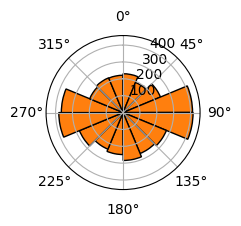

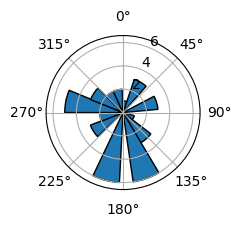

In [6]:
# plot distribution of angles for the train set and test set 
import numpy as np
import matplotlib.pyplot as plt

def plot_angles(target, color, save_path='circular_histogram.png'):
    angles_degrees = np.degrees(np.arctan2(target[:, 0], -target[:, 1])) # target is x, y want y
    angles_radians = np.deg2rad(angles_degrees)

    num_bins = 16
    N, bins = np.histogram(angles_radians, bins=num_bins)
    width = 2 * np.pi / num_bins

    fig = plt.figure(figsize=(2, 2))
    ax = fig.add_subplot(111, projection='polar')

    ax.bar(bins[:-1], N, width=width, bottom=0.0, color=color, align='edge', edgecolor='black')

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

    ax.set_ylim(0, max(N) * 1.1) 
    plt.savefig(save_path)

plot_angles(train_target_cont, color='#ff7f0e', save_path='./figures/train_dist.pdf')
plot_angles(test_target_cont, color='#1f77b4', save_path='./figures/test_dist.pdf')

# sanity check videos
# right_vid1 = 'fdbe0fbc-90a3-41b9-8898-a0c7ce3f966c.mp4'
# down_vid1 = 'c7e0c1d9-3481-4a40-9ce7-c4ab39a032db.mp4'
# left_vid1 = 'b46da39f-a64d-43f3-bc43-f601e256c9df.mp4'
# up_vid1 = 'a448297b-ae62-4712-bc4f-849b39176558.mp4'
# plot_angles(train_target_cont[train_stimuli == down_vid1[:-4]], save_path='train_dist.png')

In [7]:
from copy import deepcopy

# fit 1 binary classification optic flow model and report score
binary_model = OpticFlowDecoder(binary=True)
cv_accuracy = binary_model.train(train_pred, train_target_bin)
test_accuracy = binary_model.test(test_pred, test_target_bin)

binary_shuf_model = OpticFlowDecoder(binary=True)
train_target_bin_shuf = deepcopy(train_target_bin)
np.random.shuffle(train_target_bin_shuf)
cv_accuracy_shuf = binary_shuf_model.train(train_pred, train_target_bin_shuf)
test_accuracy_shuf = binary_shuf_model.test(test_pred, test_target_bin)

print("results for binary left/right classifier...")
print(f"==TRUE== cross validated accuracy across 5 splits: {cv_accuracy}")
print(f"==TRUE== test accuracy: {test_accuracy}")
print(f"==SHUF== cross validated accuracy across 5 splits: {cv_accuracy_shuf}")
print(f"==SHUF== test accuracy: {test_accuracy_shuf}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to

results for binary left/right classifier...
==TRUE== cross validated accuracy across 5 splits: [0.91480821]
==TRUE== test accuracy: 0.875
==SHUF== cross validated accuracy across 5 splits: [0.62711864]
==SHUF== test accuracy: 0.55


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
# fit 1 continuous optic flow model and report score
# seed np
np.random.seed(42)
cond_model = OpticFlowDecoder(binary=False)
cv_mae = cond_model.train(train_pred, train_target_cont)
test_mae = cond_model.test(test_pred, test_target_cont)

cond_shuf_model = OpticFlowDecoder(binary=False)
train_target_cont_shuf = deepcopy(train_target_cont)
np.random.shuffle(train_target_cont_shuf)
cv_mae_shuf = cond_shuf_model.train(train_pred, train_target_cont_shuf)
test_mae_shuf = cond_shuf_model.test(test_pred, test_target_cont)

print("results for continuous angle classifier...")
print(f"==TRUE== cross validated mae across 5 splits: {cv_mae}")
print(f"==TRUE== test mae: {test_mae}")
print(f"==SHUF== cross validated mae across 5 splits: {cv_mae_shuf}")
print(f"==SHUF== test mae: {test_mae_shuf}")

results for continuous angle classifier...
==TRUE== cross validated mae across 5 splits: [0.90985224]
==TRUE== test mae: 0.9233646465102346
==SHUF== cross validated mae across 5 splits: [0.110566]
==SHUF== test mae: 0.10456234485339391


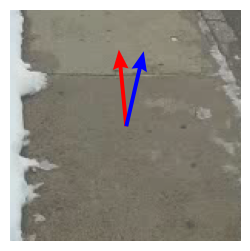

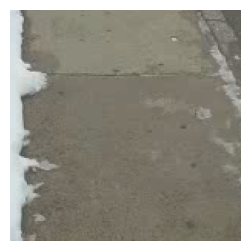

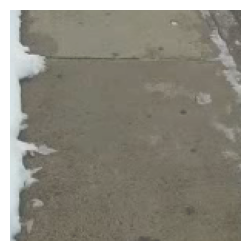

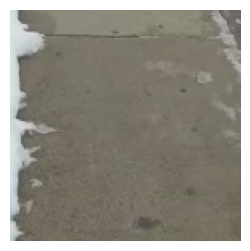

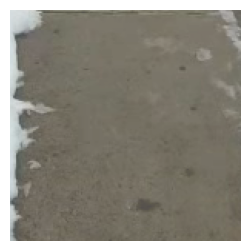

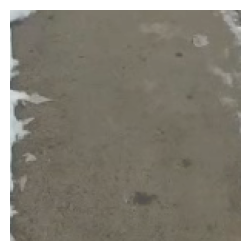

In [9]:
# plot a test set video with 'true' optic flow vector and 'predicted' optic flow vector overlayed 
def get_arrow(video_path, mean_flow_vector):
    cap = cv2.VideoCapture(video_path)
    ret, frame1 = cap.read()
    _, frame2 = cap.read()
    _, frame3 = cap.read()
    _, frame4 = cap.read()
    _, frame5 = cap.read()

    cap.release()

    arrow_frame = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    arrow_frame = crop_frame(arrow_frame)

    next_frames = [frame2, frame3, frame4, frame5]
    for i, frame in enumerate(next_frames):
        frame =  cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        next_frames[i] = crop_frame(frame)

    h, w, _ = arrow_frame.shape
    arrow_scale = 500
    mean_flow_vector = mean_flow_vector/np.sqrt(np.sum(np.square(mean_flow_vector)))
    return (arrow_frame, next_frames), w/2, h/2, mean_flow_vector[0]*arrow_scale, mean_flow_vector[1]*arrow_scale

stim_id = 38
video_path = "../dataset/dorsal_stream/" + test_stimuli[stim_id] + ".mp4"

true_flow = test_target_cont[stim_id]
pred_flow = cond_model.model.predict(test_pred)[stim_id, :]

quiver_data_true = get_arrow(video_path, true_flow)
quiver_data_pred = get_arrow(video_path, pred_flow)

plt.figure(figsize=(3,3))
plt.axis('off')
(arrow_frame, next_frames), x, y, u, v = quiver_data_true
plt.imshow(arrow_frame, alpha=0.7)
plt.quiver(x, y, u, -v, color='red', scale_units='xy', scale=10, headwidth=4, width=0.017)

(arrow_frame, next_frames), x, y, u, v = quiver_data_pred
plt.quiver(x, y, u, -v, color='blue', scale_units='xy', scale=10, headwidth=4, width=0.017)

plt.savefig("./figures/optic_flow_demo.pdf")
plt.show()
next_frames.insert(0, arrow_frame)
for ii, last_frame in enumerate(next_frames):
    plt.figure(figsize=(3,3))
    plt.axis('off')
    plt.imshow(last_frame, alpha=0.7)
    plt.savefig(f"./figures/optic_flow_demo_next_frame_{ii}.pdf")
    plt.show()

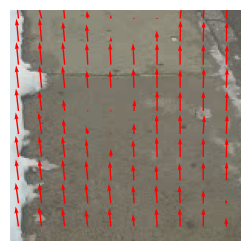

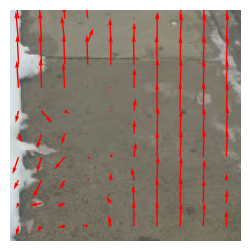

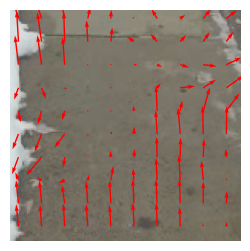

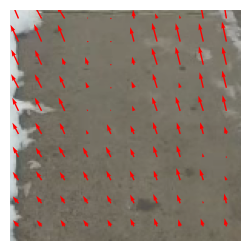

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def crop_frame(frame):
    return frame[115:115+150, 260:260+150] # crop around neuron receptive fields    

def compute_optic_flow_target_and_plot(video_path, start_frame, downsample_factor=10, arrow_scale=1.0):
    cap = cv2.VideoCapture(video_path)
    for i in range(start_frame):
        _, _ = cap.read()

    ret, first_frame_original = cap.read()


    first_frame_cropped_bgr = crop_frame(first_frame_original)
    
    prev_gray = cv2.cvtColor(first_frame_cropped_bgr, cv2.COLOR_BGR2GRAY)

    flows = []
    ret, frame = cap.read()


    gray = cv2.cvtColor(crop_frame(frame), cv2.COLOR_BGR2GRAY)
    
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    flows.append(flow)
    cap.release()
    first_frame_rgb = cv2.cvtColor(first_frame_cropped_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(3,3))
    plt.axis('off')
    plt.imshow(first_frame_rgb, alpha=0.7)

    h, w = flow.shape[:2]
    y, x = np.mgrid[5:h:downsample_factor, 5:w:downsample_factor].reshape(2, -1)
    fx, fy = flow[y, x].T

    plt.quiver(x, y, fx, fy, color='red', scale=arrow_scale, scale_units='xy', angles='xy')
    plt.savefig(f"./figures/frame_with_farneback_{start_frame}.pdf")
    plt.show()

for start_frame in range(4):
    compute_optic_flow_target_and_plot(video_path, start_frame = start_frame, downsample_factor=15, arrow_scale=0.75)

In [11]:
# neuron dropping curve for continuous decoder 
from tqdm import trange
# seed np again here

np.random.seed(42)

neuron_counts = [1, 5, 10, 25, 50, 100, 300, 1000, 1300, 2244]
num_samples = [500, 400, 200, 100, 40, 13, 5, 3, 2, 1]

val = np.zeros(len(neuron_counts))
test = np.zeros(len(neuron_counts))

for idx, neuron_count in enumerate(neuron_counts):
    val_metrics = np.zeros(num_samples[idx])
    test_metrics = np.zeros(num_samples[idx])
    for sample_idx in trange(num_samples[idx]):
        neu_idx = np.random.choice(np.arange(train_pred.shape[1]), size=neuron_counts[idx], replace=False)

        # fit 1 continuous optic flow model and report score
        cond_model = OpticFlowDecoder(binary=False)
        val_metrics[sample_idx]  = np.mean(cond_model.train(train_pred[:, neu_idx], train_target_cont))
        test_metrics[sample_idx] = cond_model.test(test_pred[:, neu_idx], test_target_cont)

    val[idx] = np.mean(val_metrics)
    test[idx] = np.mean(test_metrics)

cond_shuf_model = OpticFlowDecoder(binary=False)
train_target_cont_shuf = deepcopy(train_target_cont)
np.random.shuffle(train_target_cont_shuf)
val_shuffled = np.mean(cond_shuf_model.train(train_pred[:, neu_idx], train_target_cont_shuf))
test_shuffled = cond_shuf_model.test(test_pred[:, neu_idx], test_target_cont)

100% 500/500 [00:22<00:00, 22.13it/s]
100% 400/400 [00:18<00:00, 21.88it/s]
100% 200/200 [00:09<00:00, 20.90it/s]
100% 100/100 [00:05<00:00, 17.80it/s]
100% 40/40 [00:02<00:00, 13.87it/s]
100% 13/13 [00:01<00:00,  8.73it/s]
100% 5/5 [00:01<00:00,  3.66it/s]
100% 3/3 [00:03<00:00,  1.05s/it]
100% 2/2 [00:02<00:00,  1.50s/it]
100% 1/1 [00:02<00:00,  2.89s/it]


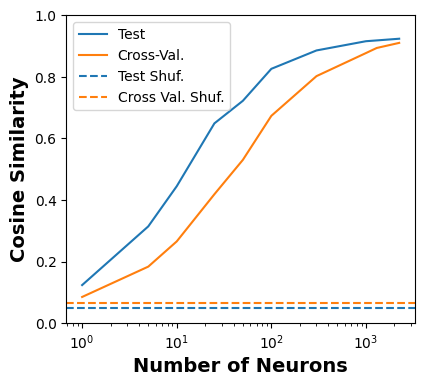

In [12]:
plt.figure(figsize=(4.5,4))
plt.plot(neuron_counts, test, label='Test')
plt.plot(neuron_counts, val, label='Cross-Val.')
plt.axhline(test_shuffled, linestyle='--', color='#1f77b4', label='Test Shuf.')
plt.axhline(val_shuffled, linestyle='--', color='#ff7f0e', label='Cross Val. Shuf.')
plt.xscale('log')
plt.xlabel("Number of Neurons", fontweight='bold', fontsize=14)
plt.ylabel("Cosine Similarity", fontweight='bold', fontsize=14)
plt.legend()
plt.ylim([0, 1])
plt.savefig(f"./figures/neuron_drop_val_and_test.pdf")
plt.show()


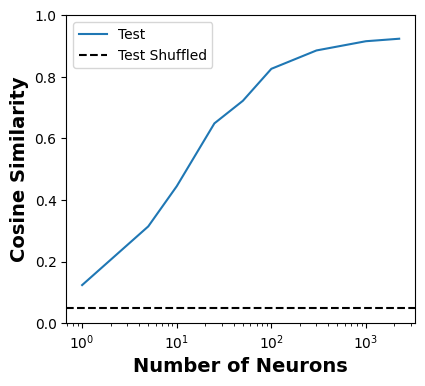

In [13]:
# neuron dropping curve
plt.figure(figsize=(4.5,4))
plt.plot(neuron_counts, test, label='Test')
plt.axhline(test_shuffled, linestyle='--', color='k', label='Test Shuffled')
plt.xscale('log')
plt.xlabel("Number of Neurons", fontweight='bold', fontsize=14)
plt.ylabel("Cosine Similarity", fontweight='bold', fontsize=14)
plt.legend()
plt.ylim([0, 1])
plt.savefig(f"./figures/neuron_drop_test.pdf")

plt.show()

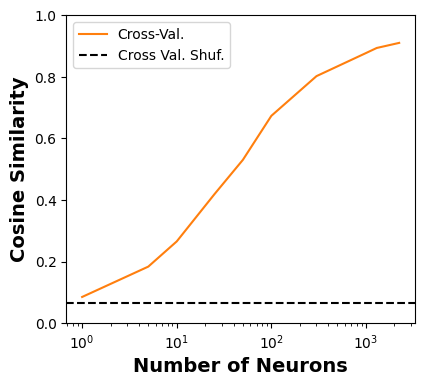

In [14]:
plt.figure(figsize=(4.5,4))
plt.plot(neuron_counts, val,color='#ff7f0e',  label='Cross-Val.')
plt.axhline(val_shuffled, linestyle='--', color='k', label='Cross Val. Shuf.')
plt.xscale('log')
plt.xlabel("Number of Neurons", fontweight='bold', fontsize=14)
plt.ylabel("Cosine Similarity", fontweight='bold', fontsize=14)
plt.legend()
plt.ylim([0, 1])
plt.savefig(f"./figures/neuron_drop_val.pdf")
plt.show()

In [15]:
# neuron dropping curves split by cell type
from tqdm import trange
# seed np again here

np.random.seed(42)
cell_types = ["RS", "FS", "AS"]

neuron_counts = [1, 5, 10, 25, 50, 100]
num_samples = [500, 400, 200, 100, 40, 13]

val_ct = np.zeros((len(cell_types), len(neuron_counts)))
test_ct =  np.zeros((len(cell_types), len(neuron_counts)))

for ct_idx, ct in enumerate(cell_types):
    ct_include_idx = cell_type == ct
    for idx, neuron_count in enumerate(neuron_counts):
        val_metrics = np.zeros(num_samples[idx])
        test_metrics = np.zeros(num_samples[idx])
        for sample_idx in trange(num_samples[idx]):
            neu_idx = np.random.choice(np.arange(train_pred[:, ct_include_idx].shape[1]), size=neuron_counts[idx], replace=False)

            # fit 1 continuous optic flow model and report score
            cond_model = OpticFlowDecoder(binary=False)
            val_metrics[sample_idx]  = np.mean(cond_model.train(train_pred[:, ct_include_idx][:, neu_idx], train_target_cont))
            test_metrics[sample_idx] = cond_model.test(test_pred[:, ct_include_idx][:, neu_idx], test_target_cont)

        val_ct[ct_idx, idx] = np.mean(val_metrics)
        test_ct[ct_idx, idx] = np.mean(test_metrics)

100% 500/500 [00:33<00:00, 14.88it/s]
100% 400/400 [00:27<00:00, 14.68it/s]
100% 200/200 [00:14<00:00, 14.22it/s]
100% 100/100 [00:07<00:00, 12.70it/s]
100% 40/40 [00:03<00:00, 10.49it/s]
100% 13/13 [00:01<00:00,  7.46it/s]
100% 500/500 [00:30<00:00, 16.26it/s]
100% 400/400 [00:25<00:00, 15.88it/s]
100% 200/200 [00:12<00:00, 15.54it/s]
100% 100/100 [00:07<00:00, 13.69it/s]
100% 40/40 [00:03<00:00, 11.33it/s]
100% 13/13 [00:01<00:00,  7.89it/s]
100% 500/500 [00:33<00:00, 14.73it/s]
100% 400/400 [00:27<00:00, 14.64it/s]
100% 200/200 [00:13<00:00, 14.30it/s]
100% 100/100 [00:07<00:00, 12.98it/s]
100% 40/40 [00:03<00:00, 10.68it/s]
100% 13/13 [00:01<00:00,  7.59it/s]


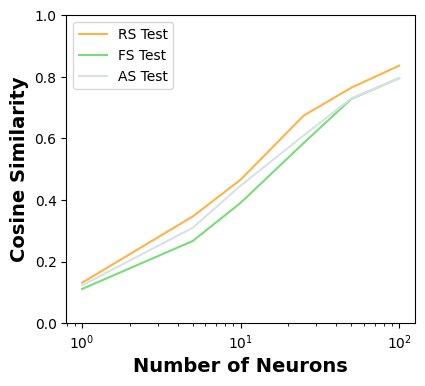

In [16]:
# plot neuron dropping curves across cell types for test set
color_map = {
    'FS': '#77DD77',  # green
    'RS': '#FFB347',  # orange
    'AS': '#d6e2e7'   # light gray-blue
}

plt.figure(figsize=(4.5,4))
for idx, ct in enumerate(cell_types):
    plt.plot(neuron_counts, test_ct[idx, :], color=color_map[ct], label=f'{ct} Test')

plt.xscale('log')
plt.xlabel("Number of Neurons", fontweight='bold', fontsize=14)
plt.ylabel("Cosine Similarity", fontweight='bold', fontsize=14)
plt.legend()
plt.ylim([0, 1])
plt.savefig(f"./figures/ct_neuron_drop_test.pdf")
plt.show()

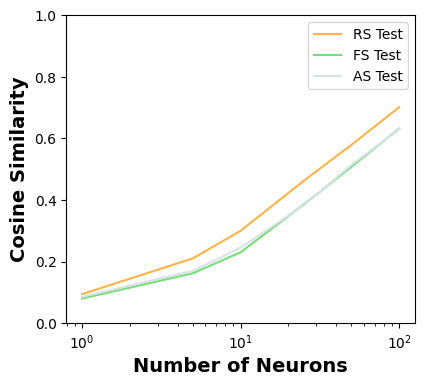

In [17]:
# plot neuron dropping curves across cell types for val set
color_map = {
    'FS': '#77DD77',  # green
    'RS': '#FFB347',  # orange
    'AS': '#d6e2e7'   # light gray-blue
}

plt.figure(figsize=(4.5,4))
for idx, ct in enumerate(cell_types):
    plt.plot(neuron_counts, val_ct[idx, :], color=color_map[ct], label=f'{ct} Test')

plt.xscale('log')
plt.xlabel("Number of Neurons", fontweight='bold', fontsize=14)
plt.ylabel("Cosine Similarity", fontweight='bold', fontsize=14)
plt.legend()
plt.ylim([0, 1])
plt.savefig(f"./figures/ct_neuron_drop_val.pdf")
plt.show()

In [18]:
# fit 1 continuous optic flow model again and report score, then visualize weights for each neuron
# seed np
np.random.seed(42)
cond_model = OpticFlowDecoder(binary=False)
cv_mae = cond_model.train(train_pred, train_target_cont)
test_mae = cond_model.test(test_pred, test_target_cont)

cond_shuf_model = OpticFlowDecoder(binary=False)
train_target_cont_shuf = deepcopy(train_target_cont)
np.random.shuffle(train_target_cont_shuf)
cv_mae_shuf = cond_shuf_model.train(train_pred, train_target_cont_shuf)
test_mae_shuf = cond_shuf_model.test(test_pred, test_target_cont)

print("results for continuous angle classifier...")
print(f"==TRUE== cross validated mae across 5 splits: {cv_mae}")
print(f"==TRUE== test mae: {test_mae}")
print(f"==SHUF== cross validated mae across 5 splits: {cv_mae_shuf}")
print(f"==SHUF== test mae: {test_mae_shuf}")

results for continuous angle classifier...
==TRUE== cross validated mae across 5 splits: [0.90985224]
==TRUE== test mae: 0.9233646465102346
==SHUF== cross validated mae across 5 splits: [0.110566]
==SHUF== test mae: 0.10456234485339391


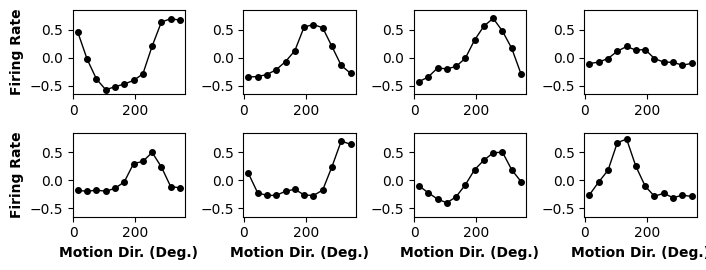

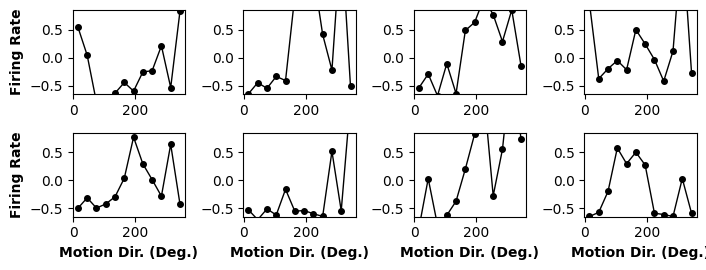

In [19]:
import pandas as pd

# weights assigned to each neuron 
weights = cond_model.model.coef_

for split in ['train', 'test']:
    # get angles in degrees for the optic flow vector assigned to each video
    if split == 'test':
        x = test_target_cont[:, 0]
        y = test_target_cont[:, 1]
    else:
        x = train_target_cont[:, 0]
        y = train_target_cont[:, 1]
    angles_radians = np.arctan2(y, x)
    angles_degrees = np.degrees(angles_radians)
    angles_degrees = (angles_degrees + 360) % 360

    # num example neurons 
    num_ex_neurons = 8
    fig, ax = plt.subplots(2, 4, figsize=(4.3*2.5/1.5, 2*2.1/1.5))

    for ii in range(2):
        for jjj in range(4):
            iii = jjj + ii * 4
            plt.sca(ax[ii, jjj])
            neu_idx = np.argsort(np.abs(weights[0, :]) + np.abs(weights[1, :]))[-(iii+1)]
            if split == 'test':
                firing_rate = test_pred[:, neu_idx]
            else:
                firing_rate = train_pred[:, neu_idx]
    
            df = pd.DataFrame({
                'angles': angles_degrees,
                'firing_rate': firing_rate
            })
            
            bin_size = 30
            bin_edges = np.arange(0, 360 + bin_size, bin_size) 
            bin_labels = [f"{i}-{i+bin_size}" for i in range(0, 360, bin_size)]
        
            df['angle_bin'] = pd.cut(df['angles'], bins=bin_edges, labels=bin_labels, right=False, include_lowest=True)
            tuning_curve_data = df.groupby('angle_bin', observed=False)['firing_rate'].mean().reset_index()
            bin_centers = np.arange(bin_size / 2, 360 + bin_size / 2, bin_size)
            tuning_curve_data['bin_center'] = bin_centers[:len(tuning_curve_data)]
            if iii+1 == 1:
                abrev = 'st'
            elif iii+1 == 2:
                abrev='nd'
            elif iii+1 == 3:
                abrev='rd'
            elif iii+1 == 4:
                abrev='th'
            label=(f'{iii+1}{abrev}')
            plt.plot(tuning_curve_data['bin_center'], tuning_curve_data['firing_rate'], 'k', marker='o', linestyle='-', linewidth=1, markersize=4,label=label)
            if jjj == 0:
                plt.ylabel('Firing Rate', fontweight='bold')
            if ii == 1:
                plt.xlabel('Motion Dir. (Deg.)', fontweight='bold')
            plt.ylim([-0.65, 0.85])
            #plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(f"./figures/tuning_{split}.pdf")
    plt.show()